## Group 10 - First Year Project 
### Data Science at ITU 
## Project 2  


# Imports

In [458]:
import numpy as np
import pandas as pd
import folium
import json
import matplotlib.pyplot as plt
from datetime import datetime
from matplotlib import rcParams
import seaborn as sns
import calmap
from scipy.stats import pearsonr, spearmanr
import statsmodels.api as sm

# Loading Data

In [459]:
PATH = {}
PATH["data_raw"] = "../data/raw/"
PATH["data_interim"] = "../data/interim/"
PATH["data_processed"] = "../data/processed/"
PATH["data_external"] = "../data/external/"

SUBPATH = {}
SUBPATH["corona"] = "corona/"
SUBPATH["meta"] = "metadata/"
SUBPATH["shape"] = "shapefiles/"
SUBPATH["weather"] = "weather/"
SUBPATH["age"] = "age/"

FILENAME = {}

FILENAME["corona"] = "de_corona.csv"
FILENAME["meta"] = "de_metadata.json"
FILENAME["shape"] = "de.geojson"
FILENAME["weather"] = "weather.csv"
FILENAME["age"] = "Altersverteilung.csv"
FILENAME["age_pop"] = "Altersverteilung_Bevolkerung.csv"

corona = PATH["data_raw"]+SUBPATH["corona"]+FILENAME["corona"]
meta = PATH["data_raw"]+SUBPATH["meta"]+FILENAME["meta"]
shape = PATH["data_raw"]+SUBPATH["shape"]+FILENAME["shape"]
weather = PATH["data_raw"]+SUBPATH["weather"]+FILENAME["weather"]
age = PATH["data_external"]+SUBPATH["age"]+FILENAME["age"]
age_pop = PATH["data_external"]+SUBPATH["age"]+FILENAME["age_pop"]

In [460]:
raw_data = {}

dateparse = lambda x: datetime.strptime(x, '%Y-%m-%d')

raw_data['corona'] = pd.read_csv(corona, sep='\s+', parse_dates=['date'], date_parser=dateparse)
raw_data['weather'] = pd.read_csv(weather, sep='\s+', parse_dates=['date'])
raw_data['age'] = pd.read_csv(age, sep=';')
raw_data['age_pop'] = pd.read_csv(age_pop, sep=';', decimal=',')

with open(meta, 'r', encoding='utf-8') as f:
    country_metadata = json.load(f)

# Dimension

In [461]:
raw_data["corona"]

,date,region_code,confirmed_addition,deceased_addition
0,2020-01-02,Nordrhein-Westfalen,1,0
1,2020-01-07,Nordrhein-Westfalen,1,0
2,2020-01-09,Nordrhein-Westfalen,1,1
3,2020-01-12,Nordrhein-Westfalen,1,0
4,2020-01-14,Nordrhein-Westfalen,1,0
...,...,...,...,...
5597,2021-02-21,Rheinland-Pfalz,120,0
5598,2021-02-21,Sachsen,68,0
5599,2021-02-21,Sachsen-Anhalt,84,0
5600,2021-02-21,Schleswig-Holstein,113,0


In [462]:
raw_data["weather"]

,date,iso3166-2,RelativeHumiditySurface,SolarRadiation,Surfacepressure,TemperatureAboveGround,Totalprecipitation,UVIndex,WindSpeed
0,2020-02-13,DE-BB,76.337444,1.824290e+06,2.403341e+06,276.551573,0.003355,2.777806,4.542822
1,2020-02-13,DE-BE,76.065297,1.786373e+06,2.408182e+06,276.844633,0.003523,4.671329,4.761509
2,2020-02-13,DE-BW,80.113988,1.505760e+06,2.290158e+06,276.227143,0.008013,4.268546,4.467024
3,2020-02-13,DE-BY,81.554346,2.363013e+06,2.275361e+06,275.583053,0.005227,4.417797,3.677414
4,2020-02-13,DE-HB,87.167414,8.389756e+03,2.406940e+06,276.237452,0.007715,1.794872,4.699573
...,...,...,...,...,...,...,...,...,...
14899,2020-11-14,SE-U,93.442738,4.831112e+04,2.410483e+06,279.246340,0.000360,0.000000,2.022863
14900,2020-11-14,SE-W,94.633991,1.790715e+04,2.316636e+06,277.356327,0.002467,0.000000,2.660086
14901,2020-11-14,SE-X,91.194131,3.040221e+04,2.371160e+06,278.566463,0.000939,0.000000,2.286798
14902,2020-11-14,SE-Y,89.264026,1.481068e+04,2.359827e+06,278.493415,0.001144,0.000000,3.152586


# Sanity Check

make a sanity check: are there missing values anywhere in the weather data?

In [463]:
print(raw_data["weather"].isna().any().any())

False


# Filter Data

### Region names with iso3166-2 codes and population

In [464]:
region_map = {country_metadata["country_metadata"][i]["covid_region_code"]: country_metadata["country_metadata"][i]["iso3166-2_code"] for i in range(len(country_metadata["country_metadata"]))}

raw_data["corona"]["region"] = raw_data["corona"]["region_code"].map(region_map)

corona_df_by_region = raw_data["corona"].groupby(by = "region")["confirmed_addition", "deceased_addition", ].sum().reset_index()


population_map = {country_metadata["country_metadata"][i]["iso3166-2_code"]: country_metadata["country_metadata"][i]["population"] for i in range(len(country_metadata["country_metadata"]))}

corona_df_by_region["population"] = corona_df_by_region["region"].map(population_map)

#corona_df_by_region

<ipython-input-464-fa3cf42dd360>:5: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  corona_df_by_region = raw_data["corona"].groupby(by = "region")["confirmed_addition", "deceased_addition", ].sum().reset_index()


### Weather in Germany

In [465]:
de_weather = raw_data["weather"][raw_data["weather"]['iso3166-2'].str.startswith('DE')]
de_weather[250:300]

,date,iso3166-2,RelativeHumiditySurface,SolarRadiation,Surfacepressure,TemperatureAboveGround,Totalprecipitation,UVIndex,WindSpeed
820,2020-02-28,DE-RP,77.587095,5.470364e+06,2.343792e+06,275.885491,0.001414,7.903213,4.601767
821,2020-02-28,DE-SH,79.631934,5.305530e+06,2.413476e+06,277.531327,0.003023,5.022788,5.514159
822,2020-02-28,DE-SL,73.167062,6.530872e+06,2.347503e+06,276.754288,0.000291,8.682065,4.818127
823,2020-02-28,DE-SN,80.968878,4.475248e+06,2.345657e+06,274.828748,0.003133,5.268251,5.216573
824,2020-02-28,DE-ST,74.604035,4.419508e+06,2.393250e+06,276.815583,0.001977,5.789261,4.997769
825,2020-02-28,DE-TH,79.831239,3.014540e+06,2.328148e+06,274.814032,0.002712,4.988582,5.492018
864,2020-02-29,DE-BB,79.560579,2.900737e+06,2.375592e+06,279.453081,0.007115,4.553603,5.320685
865,2020-02-29,DE-BE,79.086188,2.926308e+06,2.380219e+06,279.972433,0.007569,5.370629,5.602826
866,2020-02-29,DE-BW,69.740370,4.022420e+06,2.271215e+06,280.755364,0.006413,8.720129,4.874364
867,2020-02-29,DE-BY,74.130986,5.608247e+06,2.256686e+06,278.445816,0.003370,7.399952,3.978058


# Numerical summary

## Germany corona dataset

There are 16 regions

In [466]:
pd.Series(raw_data['corona']['region_code']).unique()

array(['Nordrhein-Westfalen', 'Berlin', 'Saarland', 'Bayern',
       'Niedersachsen', 'Mecklenburg-Vorpommern', 'Brandenburg',
       'Baden-Württemberg', 'Hessen', 'Rheinland-Pfalz',
       'Schleswig-Holstein', 'Hamburg', 'Bremen', 'Sachsen', 'Thüringen',
       'Sachsen-Anhalt'], dtype=object)

### Daily registered cases in Germany

In [467]:
raw_data["corona"].describe()

,confirmed_addition,deceased_addition
count,5602.000000,5602.000000
mean,426.786862,12.121028
std,831.095886,25.823844
min,1.000000,0.000000
25%,18.000000,0.000000
50%,95.000000,1.000000
75%,396.000000,10.000000
max,6809.000000,213.000000


In [468]:
rcParams['figure.figsize'] = 25,4;

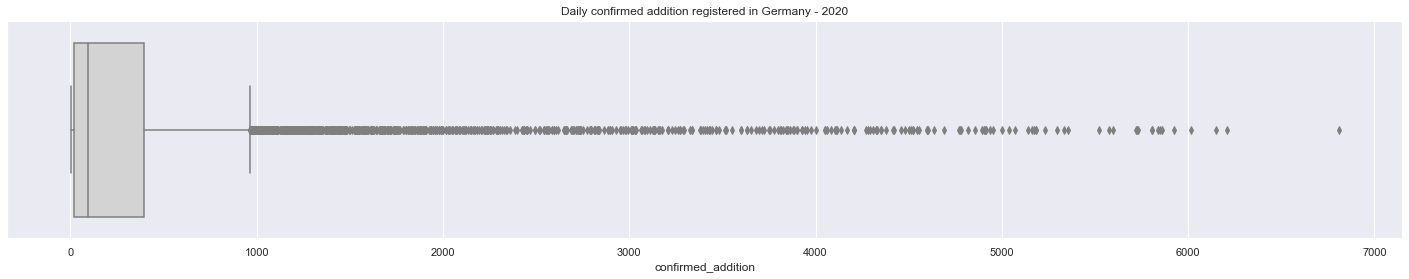

In [469]:
deCorona_confirmed = raw_data['corona']['confirmed_addition']
sns.boxplot(deCorona_confirmed, color='lightgray').set_title('Daily confirmed addition registered in Germany - 2020');
# figure size in inches


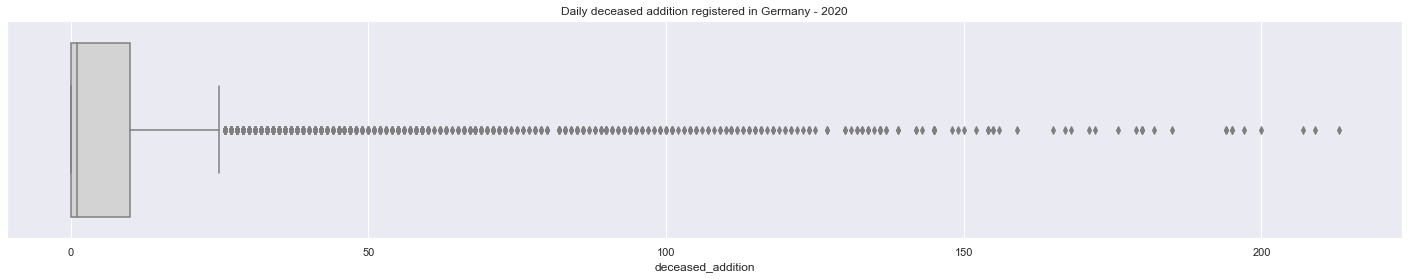

In [470]:
deCorona_deceased = raw_data['corona']['deceased_addition']
sns.boxplot(deCorona_deceased, color='lightgray').set_title('Daily deceased addition registered in Germany - 2020');

### 2020 - all registered cases in Germany

In [471]:
corona_df_by_region.describe()

,confirmed_addition,deceased_addition,population
count,16.000000,16.000000,1.600000e+01
mean,149428.750000,4243.875000,5.188701e+06
std,150077.793995,3898.816417,4.936479e+06
min,17485.000000,327.000000,6.829860e+05
25%,47996.500000,1220.000000,2.067654e+06
50%,87536.500000,2828.000000,3.270769e+06
75%,186028.750000,6119.000000,6.694969e+06
max,521548.000000,12632.000000,1.793265e+07


In [472]:
rcParams['figure.figsize'] = 5, 3;

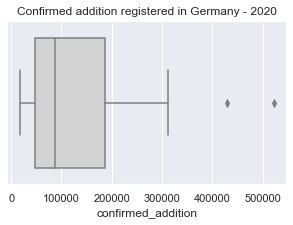

In [473]:
CoronaSUM_confirmed = corona_df_by_region['confirmed_addition']
sns.boxplot(CoronaSUM_confirmed, color='lightgray').set_title('Confirmed addition registered in Germany - 2020');

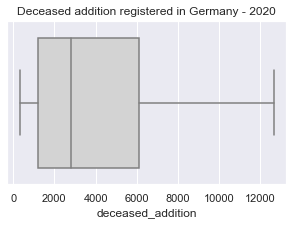

In [474]:
CoronaSUM_deceased = corona_df_by_region['deceased_addition']
sns.boxplot(CoronaSUM_deceased, color='lightgray').set_title('Deceased addition registered in Germany - 2020');

### Number of cases per capita

In [475]:
corona_df_by_region['confirmed/pop'] = corona_df_by_region['confirmed_addition']/corona_df_by_region['population']

In [476]:
corona_df_by_region['deceased/pop'] = corona_df_by_region['deceased_addition']/corona_df_by_region['population']
print(corona_df_by_region)

   region  confirmed_addition  deceased_addition  population  confirmed/pop  \
0   DE-BB               74955               2914     2511917       0.029840   
1   DE-BE              126896               2728     3644826       0.034815   
2   DE-BW              311152               7940    11069533       0.028109   
3   DE-BY              428996              12123    13076721       0.032806   
4   DE-HB               17485                327      682986       0.025601   
5   DE-HE              184434               5672     6265809       0.029435   
6   DE-HH               50291               1223     1841179       0.027315   
7   DE-MV               23436                692     1609675       0.014559   
8   DE-NI              159191               4104     7982448       0.019943   
9   DE-NW              521548              12632    17932651       0.029084   
10  DE-RP              100118               2993     4084844       0.024510   
11  DE-SH               41113               1211    

In [477]:
corona_df_by_region.groupby("region")["deceased/pop", "confirmed/pop"].describe()

<ipython-input-477-6de09c972275>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  corona_df_by_region.groupby("region")["deceased/pop", "confirmed/pop"].describe()


deceased/pop                                                        \
              count      mean std       min       25%       50%       75%   
region                                                                      
DE-BB           1.0  0.001160 NaN  0.001160  0.001160  0.001160  0.001160   
DE-BE           1.0  0.000748 NaN  0.000748  0.000748  0.000748  0.000748   
DE-BW           1.0  0.000717 NaN  0.000717  0.000717  0.000717  0.000717   
DE-BY           1.0  0.000927 NaN  0.000927  0.000927  0.000927  0.000927   
DE-HB           1.0  0.000479 NaN  0.000479  0.000479  0.000479  0.000479   
DE-HE           1.0  0.000905 NaN  0.000905  0.000905  0.000905  0.000905   
DE-HH           1.0  0.000664 NaN  0.000664  0.000664  0.000664  0.000664   
DE-MV           1.0  0.000430 NaN  0.000430  0.000430  0.000430  0.000430   
DE-NI           1.0  0.000514 NaN  0.000514  0.000514  0.000514  0.000514   
DE-NW           1.0  0.000704 NaN  0.000704  0.000704  0.000704  0.000704   
DE-RP           1.0  0.000733 NaN  0.000733  0.000733  0.000733  0.000733   
DE-SH           1.0  0.000418 NaN  0.000418  0.000418  0.000418  0.000418   
DE-SL           1.0  0.000856 NaN  0.000856  0.000856  0.000856  0.000856   
DE-SN           1.0  0.001829 NaN  0.001829  0.001829  0.001829  0.001829   
DE-ST           1.0  0.001038 NaN  0.001038  0.001038  0.001038  0.001038   
DE-TH           1.0  0.001279 NaN  0.001279  0.001279  0.001279  0.001279   

                 confirmed/pop                                              \
             max         count      mean std       min       25%       50%   
region                                                                       
DE-BB   0.001160           1.0  0.029840 NaN  0.029840  0.029840  0.029840   
DE-BE   0.000748           1.0  0.034815 NaN  0.034815  0.034815  0.034815   
DE-BW   0.000717           1.0  0.028109 NaN  0.028109  0.028109  0.028109   
DE-BY   0.000927           1.0  0.032806 NaN  0.032806  0.032806  0.032806   
DE-HB   0.000479           1.0  0.025601 NaN  0.025601  0.025601  0.025601   
DE-HE   0.000905           1.0  0.029435 NaN  0.029435  0.029435  0.029435   
DE-HH   0.000664           1.0  0.027315 NaN  0.027315  0.027315  0.027315   
DE-MV   0.000430           1.0  0.014559 NaN  0.014559  0.014559  0.014559   
DE-NI   0.000514           1.0  0.019943 NaN  0.019943  0.019943  0.019943   
DE-NW   0.000704           1.0  0.029084 NaN  0.029084  0.029084  0.029084   
DE-RP   0.000733           1.0  0.024510 NaN  0.024510  0.024510  0.024510   
DE-SH   0.000418           1.0  0.014193 NaN  0.014193  0.014193  0.014193   
DE-SL   0.000856           1.0  0.028325 NaN  0.028325  0.028325  0.028325   
DE-SN   0.001829           1.0  0.046792 NaN  0.046792  0.046792  0.046792   
DE-ST   0.001038           1.0  0.026570 NaN  0.026570  0.026570  0.026570   
DE-TH   0.001279           1.0  0.034390 NaN  0.034390  0.034390  0.034390   

                            
             75%       max  
region                      
DE-BB   0.029840  0.029840  
DE-BE   0.034815  0.034815  
DE-BW   0.028109  0.028109  
DE-BY   0.032806  0.032806  
DE-HB   0.025601  0.025601  
DE-HE   0.029435  0.029435  
DE-HH   0.027315  0.027315  
DE-MV   0.014559  0.014559  
DE-NI   0.019943  0.019943  
DE-NW   0.029084  0.029084  
DE-RP   0.024510  0.024510  
DE-SH   0.014193  0.014193  
DE-SL   0.028325  0.028325  
DE-SN   0.046792  0.046792  
DE-ST   0.026570  0.026570  
DE-TH   0.034390  0.034390

### The number of days when more than 500 /1000 confirmed addition were registered by region

In [478]:
rcParams['figure.figsize'] = 15,6;

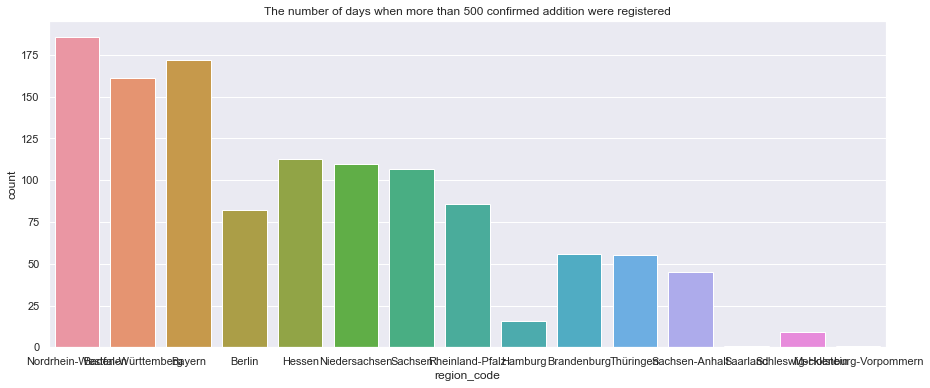

In [479]:
sns.set(style="darkgrid")
moreThan500 = (raw_data['corona']['confirmed_addition']>500)
ax = sns.countplot(x="region_code", data=raw_data['corona'][moreThan500]).set_title('The number of days when more than 500 confirmed addition were registered');

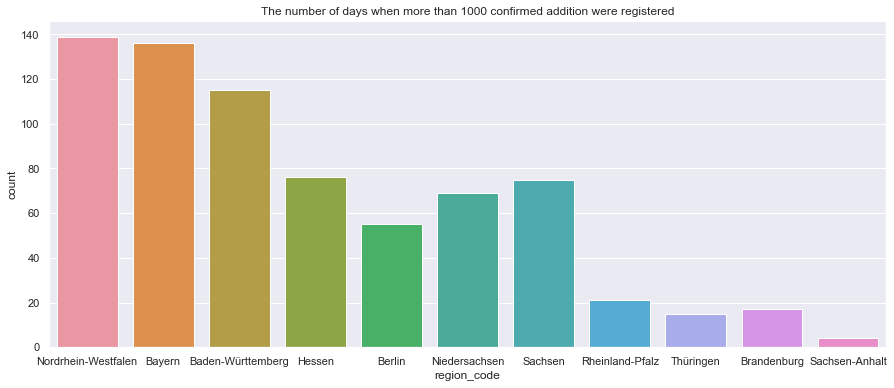

In [480]:
sns.set(style="darkgrid")
moreThan1000 = (raw_data['corona']['confirmed_addition']>1000)
ax = sns.countplot(x="region_code", data=raw_data['corona'][moreThan1000]).set_title('The number of days when more than 1000 confirmed addition were registered')

### The number of cases by region per capita

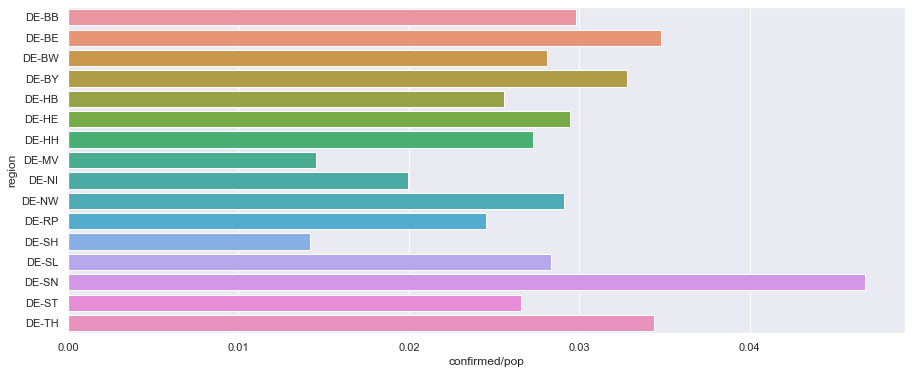

In [481]:
ax = sns.barplot(x="confirmed/pop", y="region", data=corona_df_by_region);

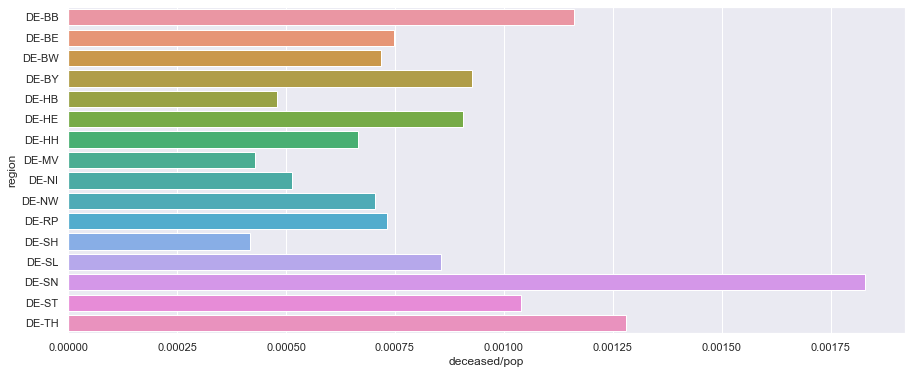

In [482]:
ax = sns.barplot(x="deceased/pop", y="region", data=corona_df_by_region)

### The number of cases monthly in Germany

In [483]:
#raw_data['corona'].reset_index(inplace=True)
#df.columns = ['Date','sum']
raw_data['corona'].head()
raw_data['corona']['year_month'] = raw_data['corona']['date'].dt.strftime('%Y-%m')
#raw_data['corona']['year_month']

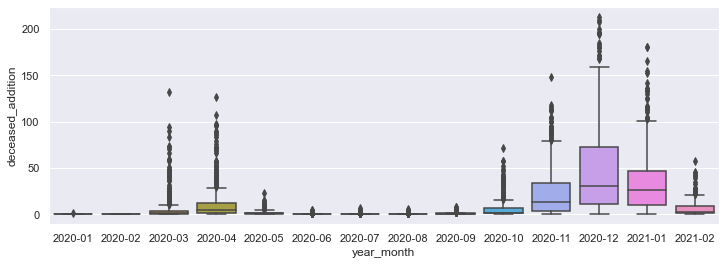

In [484]:
fig, ax = plt.subplots()
fig.set_size_inches((12,4))
sns.boxplot(x= 'year_month', y='deceased_addition',data=raw_data['corona'],ax=ax).set_title("")
plt.show()

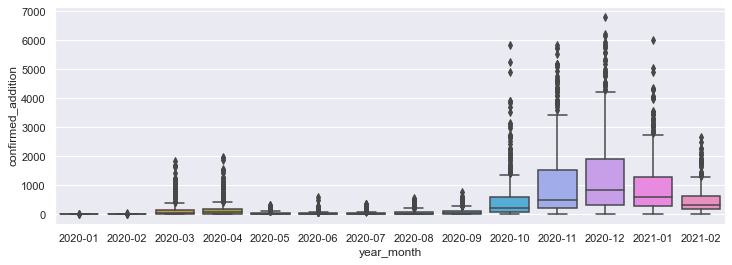

In [485]:
fig, ax = plt.subplots()
fig.set_size_inches((12,4))
sns.boxplot(x='year_month',y='confirmed_addition',data=raw_data['corona'],ax=ax).set_title("")
plt.show()

### Heatmaps of weather data daily over 2020  (02.13-11.14.)

In [486]:
#set the date as indicies for the heatmap -> df2
datetime_series = pd.to_datetime(de_weather['date'])
datetime_index = pd.DatetimeIndex(datetime_series.values)
df2=de_weather.set_index(datetime_index)
df2.drop('date', axis=1,inplace=True)
#df2;

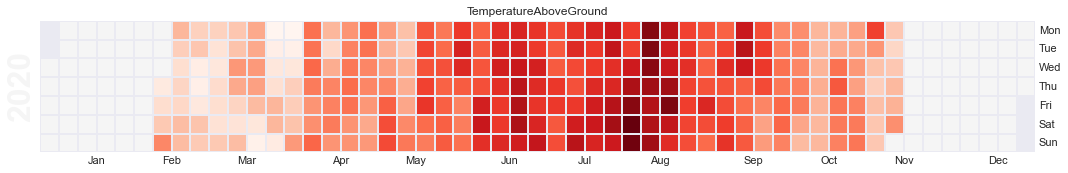

In [487]:
calmap.calendarplot(df2['TemperatureAboveGround'])
plt.title("TemperatureAboveGround");

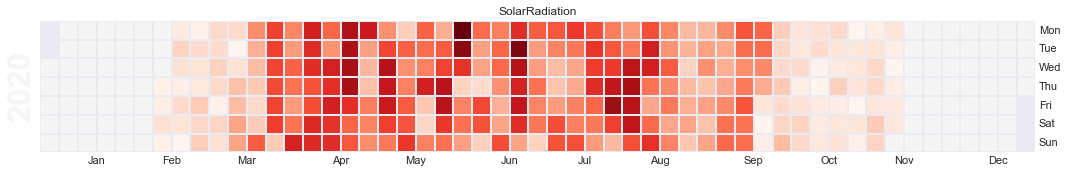

In [488]:
calmap.calendarplot(df2['SolarRadiation'])
plt.title("SolarRadiation");

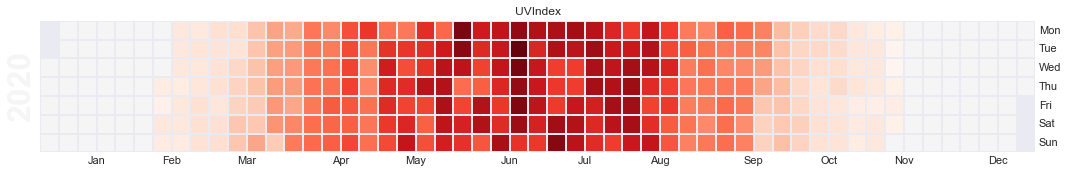

In [489]:
calmap.calendarplot(df2['UVIndex'])
plt.title("UVIndex");

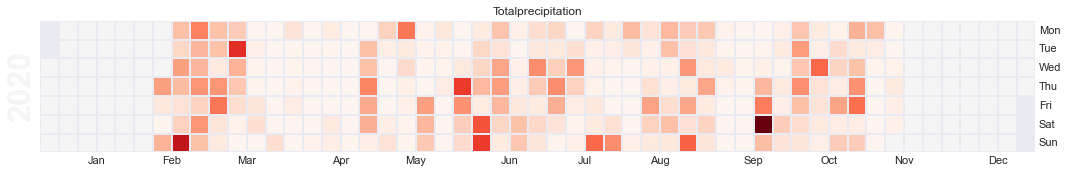

In [490]:
calmap.calendarplot(df2['Totalprecipitation'])
plt.title("Totalprecipitation");

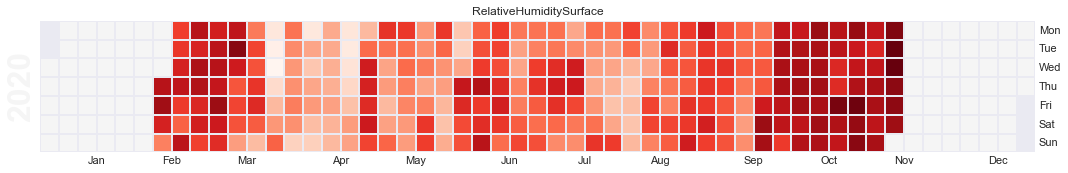

In [491]:
calmap.calendarplot(df2['RelativeHumiditySurface'])
plt.title("RelativeHumiditySurface");

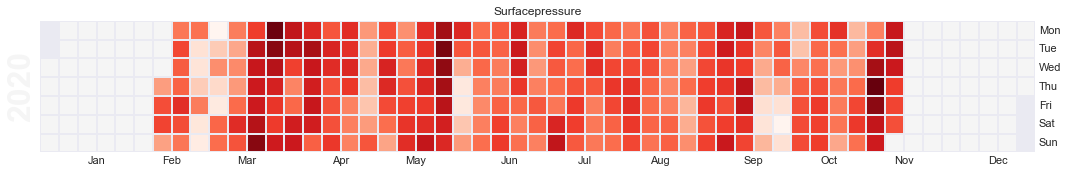

In [492]:
calmap.calendarplot(df2['Surfacepressure'])
plt.title('Surfacepressure');

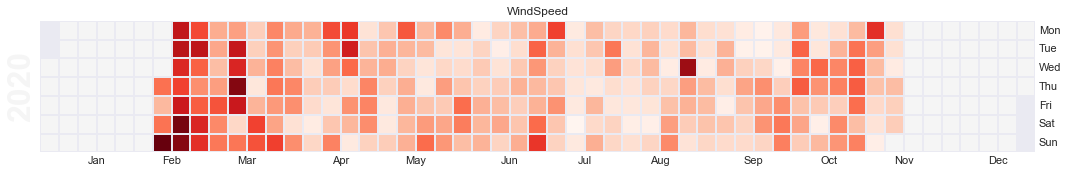

In [493]:
calmap.calendarplot(df2['WindSpeed'])
plt.title("WindSpeed");

##  Task 4: Open question
Use the data to formulate, motivate, answer, and discuss another research question of your choice. For example, compare your country to another one in the dataset; or investigate additional variables that you could
find elsewhere (e.g. total population, population density, population demographics such as age distribution,
number of elders, etc); or identify if there are temporal patterns (is one variable more important in some
months? Are weekends different from weekdays? Etc), ..


##### We loaded an external data set from the website of 'Robert Koch Institut' (RKI) to explore the role of age in potentially driving differences in infection spread.
The data set is about  COVID-19 cases by age group / 100,000 inhabitants in Germany from the 17th of March 2020 to the 2nd of March 2021.  
https://www.rki.de/DE/Content/InfAZ/N/Neuartiges_Coronavirus/Daten/Altersverteilung.html

In the table, age-specific infections per 100,000 inhabitants are shown. 
We added the mean of the weekly cases by age to the table to get a quick insight into the age distribution.

In [494]:
raw_data['age_pop']['mean'] = raw_data['age_pop'].mean(axis=1)
raw_data['age_pop']

,Altersgruppe,2020_11,2020_12,2020_13,2020_14,2020_15,2020_16,2020_17,2020_18,2020_19,...,2021_1,2021_2,2021_3,2021_4,2021_5,2021_6,2021_7,2021_8,2021_9,mean
0,Gesamt,7.72,26.97,40.89,43.39,32.69,20.88,14.88,8.95,7.50,...,175.00,143.11,114.96,94.16,77.74,61.19,63.13,67.90,69.71,57.935192
1,90+,1.58,12.27,51.52,142.28,151.15,103.03,70.59,34.63,25.27,...,657.56,612.36,479.32,350.41,235.59,159.16,131.22,100.84,73.87,159.798654
2,85 - 89,2.43,14.07,47.19,92.59,91.00,59.21,43.55,20.85,16.82,...,388.99,355.16,284.56,212.94,164.98,105.90,93.49,77.25,60.75,98.456731
3,80 - 84,2.58,14.21,38.92,59.68,52.12,35.85,24.95,13.72,9.08,...,232.98,203.08,161.73,127.34,95.47,69.79,60.77,54.09,46.47,59.921154
4,75 - 79,2.94,14.76,36.30,46.10,33.90,22.03,15.14,9.05,7.09,...,134.89,111.31,88.25,72.90,57.04,43.91,44.22,40.84,34.62,38.320577
5,70 - 74,3.92,16.85,36.12,38.57,28.58,17.17,11.54,7.48,5.63,...,131.35,99.64,83.39,67.58,56.23,42.89,43.30,44.88,42.21,37.538846
6,65 - 69,4.88,18.25,33.90,34.82,22.99,13.62,10.37,5.47,4.28,...,117.70,90.82,74.60,64.42,52.11,39.49,42.09,43.90,40.81,34.897692
7,60 - 64,7.56,28.28,44.74,49.26,31.80,19.25,11.93,7.17,5.88,...,164.12,133.70,110.36,90.83,74.67,56.54,57.78,62.27,60.20,50.811154
8,55 - 59,11.15,38.58,53.33,54.46,38.72,23.24,15.72,8.91,7.58,...,182.92,148.92,123.94,104.29,86.27,66.87,68.28,71.84,68.01,59.588077
9,50 - 54,14.57,46.05,59.61,55.09,38.94,23.25,14.81,9.02,7.75,...,180.13,146.03,121.99,99.64,78.98,64.17,67.23,70.53,73.04,61.416538


In [495]:
 raw_data['age_pop']['mean'].describe()

count     20.000000
mean      62.162125
std       29.404713
min       23.015769
25%       40.729519
50%       60.668846
75%       67.935962
max      159.798654
Name: mean, dtype: float64

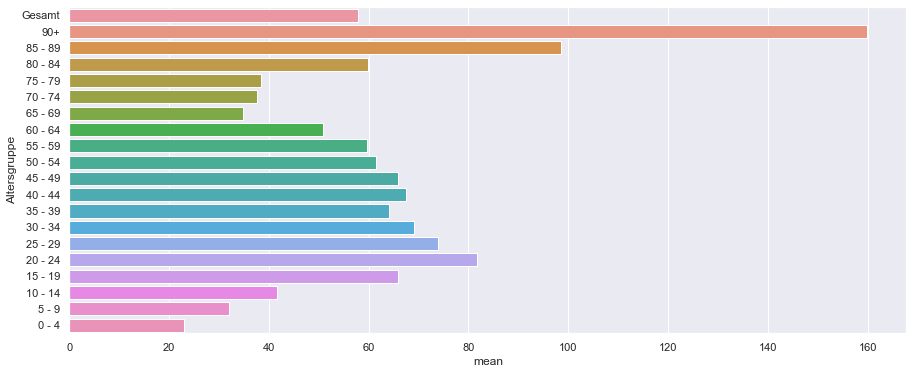

In [496]:
ax = sns.barplot(x="mean", y="Altersgruppe", data=raw_data['age_pop'])

The mean of total confirmed cases per 100,000 population across age groups show that the weekly registered infections among people above 90 is extremely hihger than other age groups. The reason could be the population size of each group.

(RKI: 40-59-year-olds make up the largest age group in Germany, at 23.6 million people, the next-largest age group was 65 years and older, at 18.09 million.) 

Now the temporal distribution of cases across age groups is to be analyzed. That needed some changes in the data structure.

In [497]:
df_T = raw_data['age_pop'].T
modified = df_T.reset_index()
new_header = modified.iloc[0] #grab the first row for the header
modified = modified[1:] #take the data less the header row
modified.columns = new_header #set the header row as the df header
modified.rename(columns={"Altersgruppe":"date"}, inplace=True)
modified = modified.drop([53])
modified['date'] = modified['date'].astype(str) + '_2' #2 means Tuesday
modified['date'] =  pd.to_datetime(modified['date'], format='%Y_%W_%w')
modified

,date,Gesamt,90+,85 - 89,80 - 84,75 - 79,70 - 74,65 - 69,60 - 64,55 - 59,...,45 - 49,40 - 44,35 - 39,30 - 34,25 - 29,20 - 24,15 - 19,10 - 14,5 - 9,0 - 4
1,2020-03-17,7.72,1.58,2.43,2.58,2.94,3.92,4.88,7.56,11.15,...,14.05,11.53,10.34,9.73,10.76,7.03,4.65,2.73,1.5,0.91
2,2020-03-24,26.97,12.27,14.07,14.21,14.76,16.85,18.25,28.28,38.58,...,39.84,36.73,33.18,37.28,39.49,31.44,13.73,6.83,4.53,3.61
3,2020-03-31,40.89,51.52,47.19,38.92,36.3,36.12,33.9,44.74,53.33,...,55.43,47.42,45.05,48,53.07,49.26,23.81,10.24,6.68,6.41
4,2020-04-07,43.39,142.28,92.59,59.68,46.1,38.57,34.82,49.26,54.46,...,51.58,47.02,41.69,44,49.01,48.69,27.34,11.61,7.86,6.87
5,2020-04-14,32.69,151.15,91,52.12,33.9,28.58,22.99,31.8,38.72,...,36.45,34.12,31.25,31.88,38.09,37.65,21.73,8.18,6.33,5.96
6,2020-04-21,20.88,103.03,59.21,35.85,22.03,17.17,13.62,19.25,23.24,...,22.26,20.9,18.57,21.89,25.56,26.78,14.52,6.37,4.37,4.06
7,2020-04-28,14.88,70.59,43.55,24.95,15.14,11.54,10.37,11.93,15.72,...,14.98,14.2,14.44,16.52,19.67,20.85,10.18,5.08,4.11,4.67
8,2020-05-05,8.95,34.63,20.85,13.72,9.05,7.48,5.47,7.17,8.91,...,8.89,9.29,8.77,10.23,13.42,12.91,6.73,3.67,3.22,3.33
9,2020-05-12,7.5,25.27,16.82,9.08,7.09,5.63,4.28,5.88,7.58,...,8.5,8.23,7.96,8.88,10.27,11.02,6.6,3.38,2.82,3.48
10,2020-05-19,5.72,17.37,11.45,7.47,4.54,3.51,3,4.25,5.34,...,6.24,7.25,6.67,7.11,7.67,9.03,4.59,3.16,2.95,2.93


In [498]:
modified['Gesamt'].describe()

count      52.00
unique     51.00
top       154.52
freq        2.00
Name: Gesamt, dtype: float64

In [499]:
for column in modified:
    modified.iloc[:, 1:21] = modified.iloc[:, 1:21].astype(float)

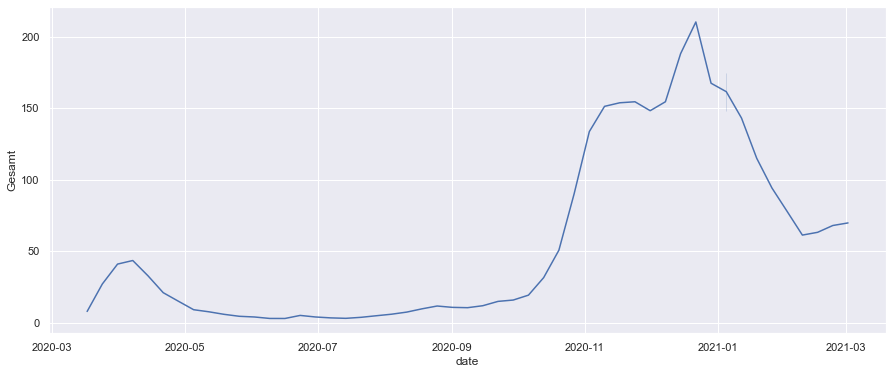

In [500]:
rcParams['figure.figsize'] = 15,6
sns.lineplot(data=modified, x='date', y='Gesamt');

The pandemic is exhibiting seasonal patterns in its spread. It is clear that there is a peak in the number of cases in the winter period of 2020-2021 and the number of cases are low during the summer. 
Next, the distribution of these specific periods will be plotted by ages.

In [501]:
x = modified.drop(['Gesamt'], axis=1)
melt_modified = x.melt('date', var_name='age_gaps',  value_name='cases')
#melt_modified[:54]
#melt_modified['date']
mask_winter = (melt_modified['date'].dt.month > 10)
mask_summer = ((melt_modified['date'].dt.month < 9) & (melt_modified['date'].dt.month > 5))
winter = melt_modified[mask_winter]
summer = melt_modified[mask_summer]

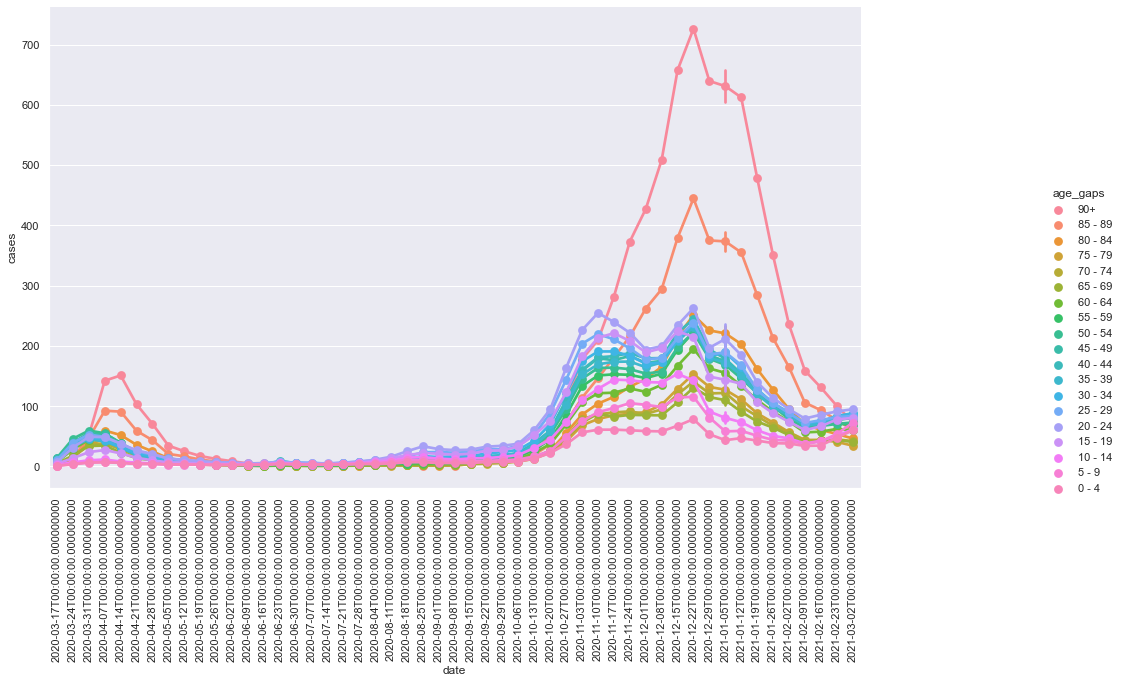

In [502]:
g = sns.catplot(x="date", y="cases", hue='age_gaps', data=melt_modified, kind='point')
g.fig.set_size_inches(20,8)
g.set_xticklabels(rotation=90);

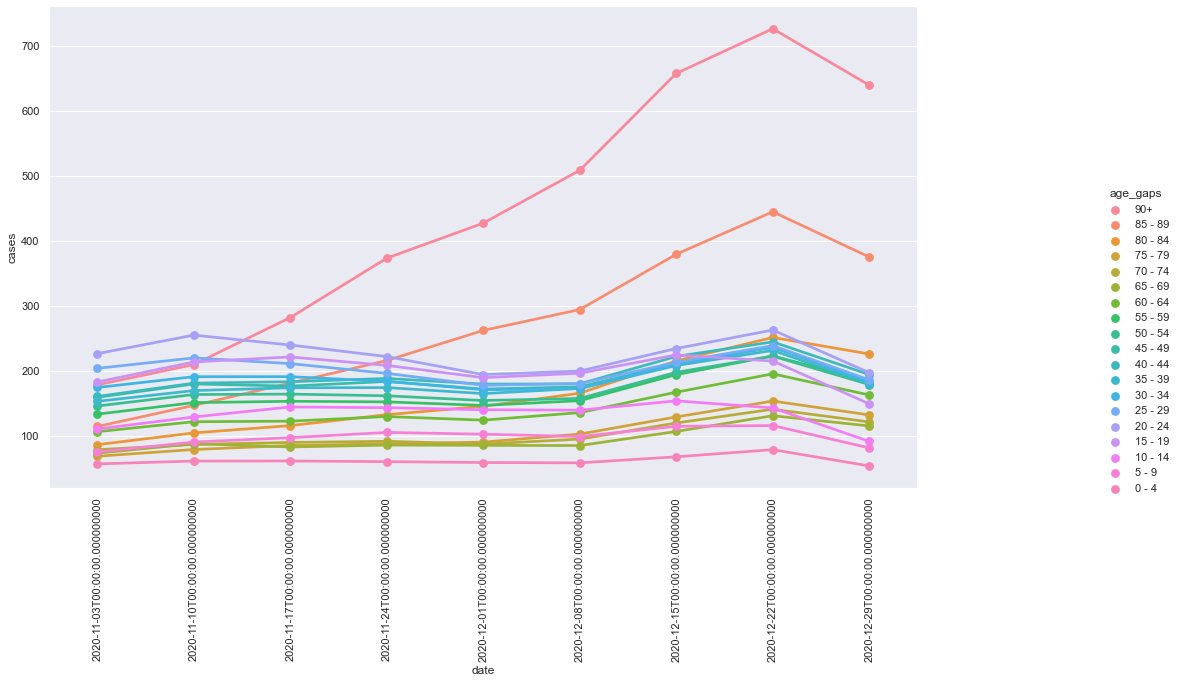

In [503]:
g = sns.catplot(x="date", y="cases", hue='age_gaps', data=winter, kind='point')
g.fig.set_size_inches(20,8)
g.set_xticklabels(rotation=90);

It is visible that the intensities of the infections across the different age groups are moving together, when entering this worst winter period, the proportion of the infected among people above 85 are ramping up more rapidly.

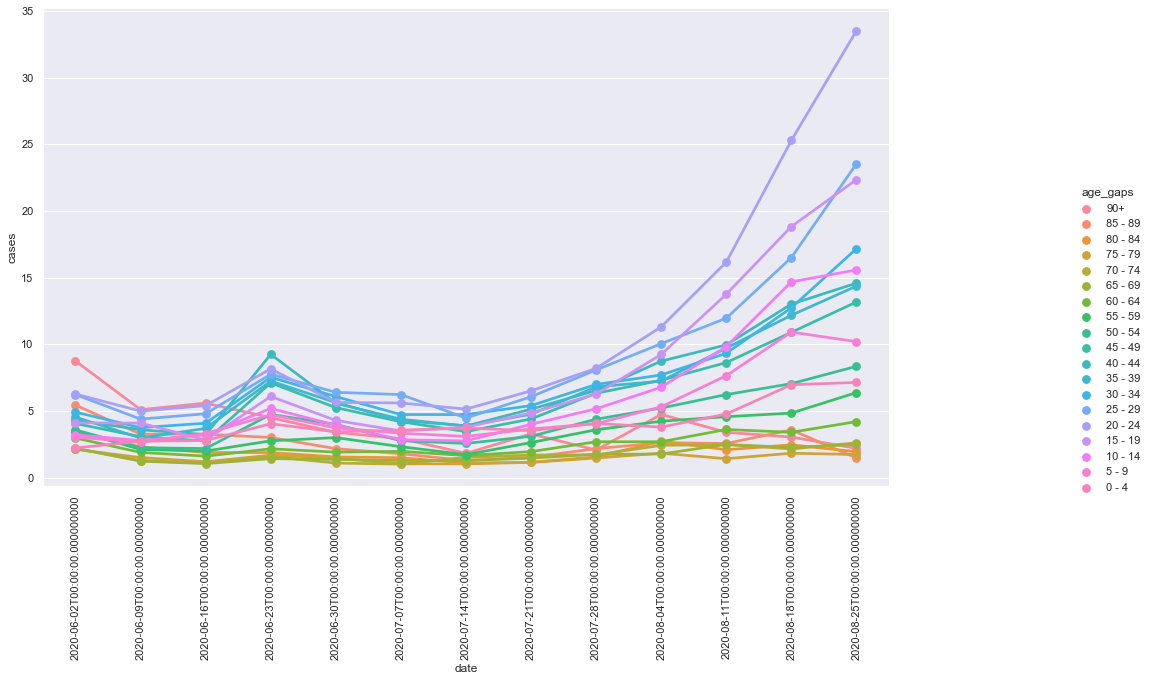

In [504]:
g = sns.catplot(x="date", y="cases", hue='age_gaps', data=summer, kind='point')
g.fig.set_size_inches(20,8)
g.set_xticklabels(rotation=90);

However, in summer time, when the number of all cases are low, the proportion of the infected among young adults are higher, among the age group 25 - 29 the highest.

By investigating the possible connections between the weather variables and the number of cases by age groups, the focus will be on the two most interesting ones that are not following the pattern: people from 25 to 29 years and above 90.

#### merge corona by age daily /weekly & weather daily / weekly

In [505]:
de_weather

,date,iso3166-2,RelativeHumiditySurface,SolarRadiation,Surfacepressure,TemperatureAboveGround,Totalprecipitation,UVIndex,WindSpeed
0,2020-02-13,DE-BB,76.337444,1.824290e+06,2.403341e+06,276.551573,0.003355,2.777806,4.542822
1,2020-02-13,DE-BE,76.065297,1.786373e+06,2.408182e+06,276.844633,0.003523,4.671329,4.761509
2,2020-02-13,DE-BW,80.113988,1.505760e+06,2.290158e+06,276.227143,0.008013,4.268546,4.467024
3,2020-02-13,DE-BY,81.554346,2.363013e+06,2.275361e+06,275.583053,0.005227,4.417797,3.677414
4,2020-02-13,DE-HB,87.167414,8.389756e+03,2.406940e+06,276.237452,0.007715,1.794872,4.699573
...,...,...,...,...,...,...,...,...,...
14861,2020-11-14,DE-SH,92.854723,7.043455e+05,2.429401e+06,283.769570,0.000243,0.033065,2.784840
14862,2020-11-14,DE-SL,87.575656,4.302501e+06,2.354934e+06,283.837352,0.000012,4.665761,3.050827
14863,2020-11-14,DE-SN,82.935273,2.388385e+06,2.362859e+06,283.909275,0.001199,2.795416,3.792073
14864,2020-11-14,DE-ST,85.289489,1.447632e+06,2.407647e+06,284.662583,0.000446,1.478117,2.738335


In [506]:
#There is data for 52 weeks: create daily data - divide the case numbers by 7
modified['date'] = pd.to_datetime(modified['date'])
daily_age = modified.set_index('date').resample('d').mean().ffill().div(7).reset_index()
#daily_age

#changes in weathe data: no need for regions - change values: sum and mean
df_w = de_weather.copy()
df_w_sum = df_w.groupby('date')['RelativeHumiditySurface', 'SolarRadiation', 'Surfacepressure', 'Totalprecipitation'].sum()
df_w_mean = df_w.groupby('date')['TemperatureAboveGround', 'UVIndex', 'WindSpeed'].mean()
df_w_noregions = df_w_sum.merge(df_w_mean, left_on = ["date"], right_on = ["date"]) 

daily_coronaAge_weather = daily_age.merge(df_w_noregions,  left_on = ["date"], right_on = ["date"])
daily_coronaAge_weather = daily_coronaAge_weather.drop_duplicates(subset='date')
daily_coronaAge_weather
#df_w

<ipython-input-506-774cafaeee14>:8: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df_w_sum = df_w.groupby('date')['RelativeHumiditySurface', 'SolarRadiation', 'Surfacepressure', 'Totalprecipitation'].sum()
<ipython-input-506-774cafaeee14>:9: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df_w_mean = df_w.groupby('date')['TemperatureAboveGround', 'UVIndex', 'WindSpeed'].mean()


,date,Gesamt,90+,85 - 89,80 - 84,75 - 79,70 - 74,65 - 69,60 - 64,55 - 59,...,10 - 14,5 - 9,0 - 4,RelativeHumiditySurface,SolarRadiation,Surfacepressure,Totalprecipitation,TemperatureAboveGround,UVIndex,WindSpeed
0,2020-03-17,1.102857,0.225714,0.347143,0.368571,0.420000,0.560000,0.697143,1.080000,1.592857,...,0.39,0.214286,0.13,1160.515753,1.054981e+08,3.854736e+07,0.007915,282.061149,10.491478,2.803467
1,2020-03-18,1.102857,0.225714,0.347143,0.368571,0.420000,0.560000,0.697143,1.080000,1.592857,...,0.39,0.214286,0.13,1128.180200,9.076108e+07,3.847567e+07,0.002819,283.142310,10.793223,3.395960
2,2020-03-19,1.102857,0.225714,0.347143,0.368571,0.420000,0.560000,0.697143,1.080000,1.592857,...,0.39,0.214286,0.13,1200.352719,7.485194e+07,3.844400e+07,0.003419,282.666685,10.961985,2.190335
3,2020-03-20,1.102857,0.225714,0.347143,0.368571,0.420000,0.560000,0.697143,1.080000,1.592857,...,0.39,0.214286,0.13,1226.824837,5.469901e+07,3.844265e+07,0.024610,280.663149,9.631838,3.369490
4,2020-03-21,1.102857,0.225714,0.347143,0.368571,0.420000,0.560000,0.697143,1.080000,1.592857,...,0.39,0.214286,0.13,1103.812108,7.369057e+07,3.857208e+07,0.032499,276.587358,10.056526,5.502687
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
238,2020-11-10,21.615714,29.924286,20.947143,14.904286,11.254286,12.368571,12.524286,17.361429,21.562857,...,18.41,12.890000,8.72,1490.276902,1.889390e+07,3.854256e+07,0.000933,278.386766,1.032930,2.424941
239,2020-11-11,21.615714,29.924286,20.947143,14.904286,11.254286,12.368571,12.524286,17.361429,21.562857,...,18.41,12.890000,8.72,1487.195632,5.066757e+06,3.845613e+07,0.005544,279.602605,0.473817,2.025096
240,2020-11-12,21.615714,29.924286,20.947143,14.904286,11.254286,12.368571,12.524286,17.361429,21.562857,...,18.41,12.890000,8.72,1428.244244,2.054555e+07,3.824626e+07,0.016287,280.757227,1.994895,3.203011
241,2020-11-13,21.615714,29.924286,20.947143,14.904286,11.254286,12.368571,12.524286,17.361429,21.562857,...,18.41,12.890000,8.72,1422.514805,3.287526e+07,3.820998e+07,0.010258,281.342447,2.648182,2.808139


In [507]:
#weekly for plots
weather_week = de_weather.groupby('iso3166-2').resample('W-Tue', on='date').sum().reset_index().sort_values(by='date')
#weather_week[:32]
weather_week = weather_week.resample('d', on='date').mean().dropna(how='all')
weather_week.reset_index(level=0, inplace=True)
#weather_week: 3.17-3.02
weekly_coronaAge_weather = modified.merge(weather_week, left_on = ["date"], right_on = ["date"])
weekly_coronaAge_weather.drop_duplicates(subset='date')
weekly_coronaAge_weather.head()

,date,Gesamt,90+,85 - 89,80 - 84,75 - 79,70 - 74,65 - 69,60 - 64,55 - 59,...,10 - 14,5 - 9,0 - 4,RelativeHumiditySurface,SolarRadiation,Surfacepressure,TemperatureAboveGround,Totalprecipitation,UVIndex,WindSpeed
0,2020-03-17,7.72,1.58,2.43,2.58,2.94,3.92,4.88,7.56,11.15,...,2.73,1.50,0.91,488.505194,4.400688e+07,1.668763e+07,1965.628348,0.010969,65.733234,32.973759
1,2020-03-24,26.97,12.27,14.07,14.21,14.76,16.85,18.25,28.28,38.58,...,6.83,4.53,3.61,433.717130,5.834713e+07,1.689254e+07,1948.161650,0.003970,87.738328,27.880906
2,2020-03-31,40.89,51.52,47.19,38.92,36.30,36.12,33.90,44.74,53.33,...,10.24,6.68,6.41,399.518901,7.676993e+07,1.681299e+07,1941.532918,0.003975,107.636345,28.400389
3,2020-04-07,43.39,142.28,92.59,59.68,46.10,38.57,34.82,49.26,54.46,...,11.61,7.86,6.87,398.788265,8.925629e+07,1.675362e+07,1970.426096,0.001393,131.081748,24.325035
4,2020-04-14,32.69,151.15,91.00,52.12,33.90,28.58,22.99,31.80,38.72,...,8.18,6.33,5.96,387.183974,9.258561e+07,1.677470e+07,1986.150186,0.001358,151.104412,21.817924


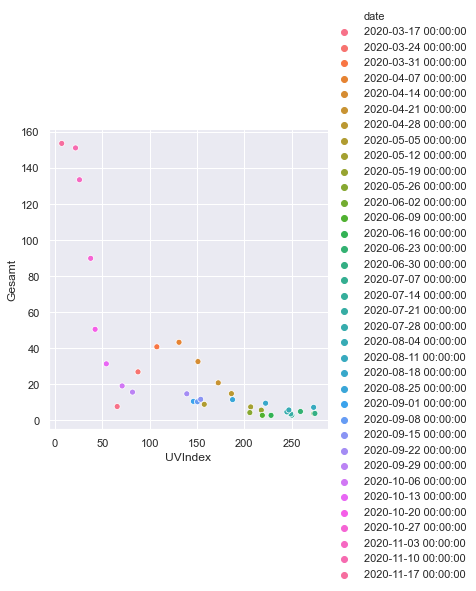

In [508]:
sns.relplot(x="UVIndex", y="Gesamt", hue="date", data=weekly_coronaAge_weather);

The scatterplot shows a chance for some association between the UVIndex and the total number of cases in Germany. Around April and May there are some exeptions.

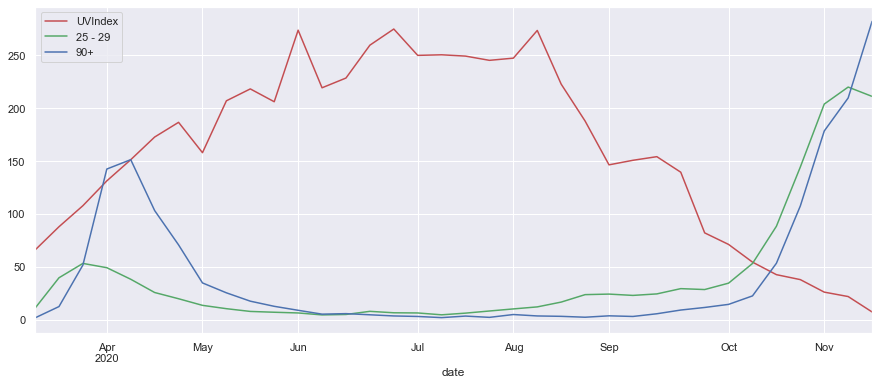

In [509]:
ax1 = weekly_coronaAge_weather.plot(kind='line', x='date', y='UVIndex', color='r')    
ax2 = weekly_coronaAge_weather.plot(kind='line', x='date', y='25 - 29', color='g', ax=ax1)    
ax3 = weekly_coronaAge_weather.plot(kind='line', x='date', y='90+', color='b', ax=ax1)

By looking at the plot about the oldest age group, from April to May the number of cases are going against the yearly trend.
Although From 13 March, the pandemic has been managed in the protection stage as per the RKI plan, with German states prohibiting visits to nursing homes to protect the elderly. 

In [510]:
#variables that we want to correlate with the number of cases
weather_headers = ['RelativeHumiditySurface', 'SolarRadiation', 'Surfacepressure', 'TemperatureAboveGround',
             'Totalprecipitation', 'UVIndex', 'WindSpeed']

#### Multivariable linear regression using statsmodel for daily_coronaAge_weather 90+
3.17. - 11-14.

Let's look all the weather variables. Are there any differencies how the different weather variables can influence the number of cases by that two specific age groups? 

In [511]:
#create a constant
daily_coronaAge_weather = sm.add_constant(daily_coronaAge_weather)
weather_headers.append('const')

#OLS function: first varable, that we want to explain, and take the logarithm - it incriesed R-squared, so the quality 
#second: explaining BY this dataframe
est = sm.OLS(np.log(daily_coronaAge_weather['90+']), daily_coronaAge_weather[weather_headers], hasconst = True).fit()
print(est.summary())

                            OLS Regression Results                            
Dep. Variable:                    90+   R-squared:                       0.472
Model:                            OLS   Adj. R-squared:                  0.456
Method:                 Least Squares   F-statistic:                     30.02
Date:                Sun, 14 Mar 2021   Prob (F-statistic):           1.86e-29
Time:                        14:22:15   Log-Likelihood:                -360.20
No. Observations:                 243   AIC:                             736.4
Df Residuals:                     235   BIC:                             764.3
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
RelativeHumiditySurface   

R-squared 0.438 (corr.coeff. squared) It means this model can explain the 43.8% of the variation in our data.

Looking at the p-values: There is a relationship between the daily number of cases and Humidity / Pressure / Totalprecipitation / Windspeed. 

Looking at the correlation coefficients: It seems the more it rains the lower the number of cases between people above 90. It is a negativ association, while keeping everything else constant. A possible explanation for this data is that people above 90 are more likely staying isolated in bad weahter.

#### Multivariable linear regression using statsmodel for daily_coronaAge_weather 25-29
3.17. - 11-14.

In [512]:
est = sm.OLS(np.log(daily_coronaAge_weather['25 - 29']), daily_coronaAge_weather[weather_headers], hasconst = True).fit()
print(est.summary())

                            OLS Regression Results                            
Dep. Variable:                25 - 29   R-squared:                       0.821
Model:                            OLS   Adj. R-squared:                  0.815
Method:                 Least Squares   F-statistic:                     153.7
Date:                Sun, 14 Mar 2021   Prob (F-statistic):           5.39e-84
Time:                        14:22:15   Log-Likelihood:                -144.76
No. Observations:                 243   AIC:                             305.5
Df Residuals:                     235   BIC:                             333.5
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
RelativeHumiditySurface   

R-squared 0.757. (corr.coeff. squared) It means this model can explain the 75.7% of the variation in our data. !!! 

Looking at the p-values: There is a relationship between the daily number of cases and Humidity / Pressure / Temperature / totalprecipitation / Windspeed. 

Looking at the correlation coefficients: ...

In [514]:
est = sm.OLS(np.log(daily_coronaAge_weather['40 - 44']), daily_coronaAge_weather[weather_headers], hasconst = True).fit()
print(est.summary())

                            OLS Regression Results                            
Dep. Variable:                40 - 44   R-squared:                       0.787
Model:                            OLS   Adj. R-squared:                  0.780
Method:                 Least Squares   F-statistic:                     123.9
Date:                Sun, 14 Mar 2021   Prob (F-statistic):           3.42e-75
Time:                        14:30:13   Log-Likelihood:                -162.50
No. Observations:                 243   AIC:                             341.0
Df Residuals:                     235   BIC:                             368.9
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
RelativeHumiditySurface   